# Setup

In [ ]:
pip install -q -U tensorflow-addons

     |████████████████████████████████| 686kB 13.1MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers, initializers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Mean
from google.colab import drive
import numpy as np
import os
from tqdm.autonotebook import tqdm
from IPython.display import Image
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import shutil
from functools import partial

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
%cd /content/
drive.mount("/content/drive")

/content
Mounted at /content/drive


In [ ]:
!git clone https://github.com/yxczt/project_laboratory_elozs.git

Cloning into 'project_laboratory_elozs'...
remote: Enumerating objects: 3651, done.
remote: Counting objects: 100% (3651/3651), done.
remote: Compressing objects: 100% (3647/3647), done.
remote: Total 3651 (delta 2), reused 3642 (delta 1), pack-reused 0
Receiving objects: 100% (3651/3651), 23.16 MiB | 22.93 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [ ]:
%cd /content/project_laboratory_elozs/
!ls -a

/content/project_laboratory_elozs
.  ..  data  .git  README.md


In [ ]:
def pbar(total_images, batch_size, epoch, epochs):
    bar = tqdm(total=(total_images // batch_size) * batch_size,
               ncols=int(get_terminal_width() * .9),
               desc=tqdm.write(f'Epoch {epoch + 1}/{epochs}'),
               postfix={
                   'g_loss': f'{0:6.3f}',
                   'd_loss': f'{0:6.3f}',
                   1: 1
               },
               bar_format='{n_fmt}/{total_fmt} |{bar}| {rate_fmt}  '
               'ETA: {remaining}  Elapsed Time: {elapsed}  '
               'G Loss: {postfix[g_loss]}  D Loss: {postfix['
               'd_loss]}',
               unit=' images',
               miniters=10)
    return bar

In [ ]:
def save_image_grid(img_grid, epoch):
    file_name = 'Final' + f'_{epoch}.png'
    output_dir = os.path.join("/content/drive/MyDrive/onlab_results/training/", file_name)
    tf.io.write_file(output_dir, tf.image.encode_png(tf.cast(img_grid, tf.uint8)))

In [ ]:
def img_merge(images, n_rows=None, n_cols=None, padding=0, pad_value=0):
    images = (tf.cast(images, tf.float32) + 1.0) * 127.5
    images = np.array(images)
    n = images.shape[0]

    if n_rows:
        n_rows = max(min(n_rows, n), 1)
        n_cols = int(n - 0.5) // n_rows + 1
    elif n_cols:
        n_cols = max(min(n_cols, n), 1)
        n_rows = int(n - 0.5) // n_cols + 1
    else:
        n_rows = int(n**0.5)
        n_cols = int(n - 0.5) // n_rows + 1

    h, w = images.shape[1], images.shape[2]
    shape = (h * n_rows + padding * (n_rows - 1), w * n_cols + padding * (n_cols - 1))
    if images.ndim == 4:
        shape += (images.shape[3], )
    img = np.full(shape, pad_value, dtype=images.dtype)

    for idx, image in enumerate(images):
        i = idx % n_cols
        j = idx // n_cols
        img[j * (h + padding):j * (h + padding) + h, i * (w + padding):i *
            (w + padding) + w, ...] = image
    return img

In [ ]:
def get_terminal_width():
    width = shutil.get_terminal_size(fallback=(200, 24))[0]
    if width == 0:
        width = 120
    return width

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
  ):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x
    
def conv_block(
  x,
  filters,
  activation,
  kernel_size=(3, 3),
  strides=(1, 1),
  padding="same",
  use_bias=True,
  use_bn=False,
  use_dropout=False,
  drop_value=0.5,
):
  x = layers.Conv2D(
      filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
  )(x)
  if use_bn:
      x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
      x = layers.Dropout(drop_value)(x)
  return x

def down_new_block(n_filters, kernel_size, input_layer, strides = (1, 1)):
  init = initializers.RandomNormal(stddev=0.02)
  x = layers.Conv2D(n_filters, kernel_size, strides, padding='same', kernel_initializer=init)(input_layer)
  x = tfa.layers.InstanceNormalization(axis=-1)(x)
  x = layers.Activation('relu')(x)
  return x

def res_block(n_filters, input_layer):
  init = initializers.RandomNormal(stddev=0.02)
  x = down_new_block(n_filters, (3, 3), input_layer)
  x = layers.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer=init)(x)
  x = tfa.layers.InstanceNormalization(axis = -1)(x)
  x = layers.Concatenate()([x, input_layer])
  return x

def up_new_block(n_filters, input_layer):
  init = initializers.RandomNormal(stddev=0.02)
  x = layers.Conv2DTranspose(n_filters, (3, 3), (2, 2), padding='same', kernel_initializer=init)(input_layer)
  x = tfa.layers.InstanceNormalization(axis=-1)(x)
  x = layers.Activation('relu')(x)
  return x

In [ ]:
IMG_SHAPE = (128, 128, 3)
total_img_count = 1416
img_size = 128
epochs = 300
batch = 32
noise_dim = 1536

## Defining the Model

In [ ]:
class WGANGP:
  def __init__(self, num_of_images = 1416, image_size = 128, epochs = 300, batch_size = 32, z_size = 1536, n_critic = 5, gp_weight = 10.0, loading = False):
    self.num_of_images = num_of_images
    self.image_size = image_size
    self.epochs = epochs
    self.batch_size = batch_size
    self.z_size = z_size
    self.n_critic = n_critic
    self.gp_weight = gp_weight
    if loading:
      %cd /content/drive/MyDrive/onlab_results
      self.Gen = tf.keras.models.load_model("generator_full.h5")
      self.Disc = tf.keras.models.load_model("discriminator_full.h5")
    else:
      self.Gen = self.build_generator()
      self.Disc = self.build_discriminator()
    self.gen_optimizer = Adam(0.0001)
    self.disc_optimizer = Adam(0.0001)

    self.Gen.summary()
    self.Disc.summary()

  def build_generator(self):
    %cd /content/drive/MyDrive/onlab_results/first_try
    init = initializers.RandomNormal(stddev=0.02)
    gen_board = tf.keras.models.load_model("generator.h5")
    gen_pieces = tf.keras.models.load_model("generator_pieces.h5")
    for layer in gen_board.layers:
      layer.trainable = False
    for layer in gen_pieces.layers:
      layer.trainable = False
    x = layers.concatenate([gen_board.output, gen_pieces.output])
    x = layers.Conv2D(3, 1)(x)
    x = layers.Activation("relu")(x)
    x = down_new_block(64, (7, 7), x)
    x = down_new_block(128, (3, 3), x, (2, 2))
    x = down_new_block(256, (3, 3), x, (2, 2))
    for _ in range(6):
      x = res_block(256, x)
    x = up_new_block(128, x)
    x = up_new_block(64, x)
    x = layers.Conv2DTranspose(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = tfa.layers.InstanceNormalization(axis=-1)(x)
    output = layers.Activation('tanh')(x)
    g_model = Model([gen_board.input, gen_pieces.input], output, name = "generator")
    return g_model


  def build_discriminator(self):
    img_input = layers.Input(shape=IMG_SHAPE)
    x = conv_block(
        img_input,
        48,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        96,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        192,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    x = conv_block(
        x,
        384,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=False,
        drop_value=0.3,
    )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = Model(img_input, x, name="discriminator")
    return d_model

  def train(self, dataset):
    z1 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    z2 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    g_train_loss = Mean()
    d_train_loss = Mean()
    for epoch in range(self.epochs):
      bar = pbar(self.num_of_images, 32, epoch, self.epochs)
      for batch in dataset:
        for _ in range(self.n_critic):
          self.train_discrminator(batch)
          d_loss = self.train_discrminator(batch)
          d_train_loss(d_loss)

        g_loss = self.train_generator()
        g_train_loss(g_loss)
        self.train_generator()

        bar.postfix['g_loss'] = f'{g_train_loss.result():6.3f}'
        bar.postfix['d_loss'] = f'{d_train_loss.result():6.3f}'
        bar.update(self.batch_size)

      g_train_loss.reset_states()
      d_train_loss.reset_states()

      bar.close()
      del bar

      samples = self.Gen([z1, z2], training=False)
      image_grid = img_merge(samples, n_rows=8).squeeze()
      save_image_grid(image_grid, epoch + 1)
      if epoch % 5 == 0:
        self.saving_models()
  
  @tf.function
  def train_generator(self):
    z1 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    z2 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    with tf.GradientTape() as t:
      x_fake = self.Gen([z1, z2], training=True)
      fake_logits = self.Disc(x_fake, training=True)
      loss = -(tf.reduce_mean(fake_logits))
    grad = t.gradient(loss, self.Gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(grad, self.Gen.trainable_variables))
    return loss
  
  @tf.function
  def train_discrminator(self, x_real):
    z1 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    z2 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    with tf.GradientTape() as t:
      x_fake = self.Gen([z1, z2], training=True)
      fake_logits = self.Disc(x_fake, training=True)
      real_logits = self.Disc(x_real, training=True)
      cost = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)
      gp = self.gradient_penalty(partial(self.Disc, training=True), x_real, x_fake)
      cost += self.gp_weight * gp
    grad = t.gradient(cost, self.Disc.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(grad, self.Disc.trainable_variables))
    return cost

  def gradient_penalty(self, f, real, fake):
    alpha = tf.random.uniform([self.batch_size, 1, 1, 1], 0., 1.)
    diff = fake - real
    inter = real + (alpha * diff)
    with tf.GradientTape() as t:
        t.watch(inter)
        pred = f(inter)
    grad = t.gradient(pred, [inter])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=[1, 2, 3]))
    gp = tf.reduce_mean((slopes - 1.)**2)
    return gp
  
  def generate_samples(self):
    z1 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    z2 = tf.random.normal((self.batch_size, 1, 1, self.z_size))
    samples = self.Gen([z1, z2], training=False)
    image_grid = img_merge(samples, n_rows=8).squeeze()
    file_name = 'FinalGeneratedRandom.png'
    output_dir = os.path.join("/content/drive/MyDrive/onlab_results/generated_images/", file_name)
    tf.io.write_file(output_dir, tf.image.encode_png(tf.cast(image_grid, tf.uint8)))
  def saving_models(self):
    self.Gen.save('generator_full.h5')
    self.Disc.save('discriminator_full.h5')


# Dataset preparation

In [ ]:
def decode_img(file_path):
    file = tf.io.read_file(file_path)
    img = tf.image.decode_png(file, channels=3)
    img = (tf.dtypes.cast(img, tf.float32) / 127.5) - 1.0
    return img  

img_path = "/content/project_laboratory_elozs/data/full/"
ds_train_paths = tf.data.Dataset.list_files(str(img_path + '*.png'))

ds_train = ds_train_paths.map(decode_img).cache().shuffle(1416).batch(32, drop_remainder=True)

In [ ]:
unknown_image_batch = next(iter(ds_train))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


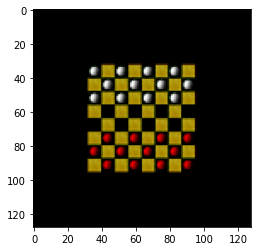

In [ ]:
img = unknown_image_batch[0]
plt.imshow(tf.concat([img], 2))

# Training

In [ ]:
%cd /content/drive/MyDrive/onlab_results/
wgan = WGANGP(loading=True)
%cd /content/drive/MyDrive/onlab_results/

/content/drive/MyDrive/onlab_results
/content/drive/MyDrive/onlab_results


Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_63 (InputLayer)           [(None, 1, 1, 1536)] 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1, 1, 1536)] 0                                            
__________________________________________________________________________________________________
dense_80 (Dense)                (None, 1, 1, 1536)   2359296     input_63[0][0]                   
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 1, 1, 1536)   2359296     input_7[0][0]                    
__________________________________________________________________________________________

In [ ]:
wgan.train(ds_train)

Epoch 1/300



Epoch 2/300



Epoch 3/300



Epoch 4/300



Epoch 5/300



Epoch 6/300



Epoch 7/300



Epoch 8/300



Epoch 9/300



Epoch 10/300



Epoch 11/300



Epoch 12/300



Epoch 13/300



Epoch 14/300



Epoch 15/300



Epoch 16/300



Epoch 17/300



Epoch 18/300



Epoch 19/300



Epoch 20/300



Epoch 21/300



Epoch 22/300



Epoch 23/300



Epoch 24/300



Epoch 25/300



Epoch 26/300



Epoch 27/300



Epoch 28/300



Epoch 29/300



Epoch 30/300



Epoch 31/300



Epoch 32/300



Epoch 33/300



Epoch 34/300



Epoch 35/300



Epoch 36/300



Epoch 37/300



Epoch 38/300



Epoch 39/300



Epoch 40/300



Epoch 41/300



Epoch 42/300



Epoch 43/300



Epoch 44/300



Epoch 45/300



Epoch 46/300



Epoch 47/300



Epoch 48/300



Epoch 49/300



Epoch 50/300



Epoch 51/300



Epoch 52/300



Epoch 53/300



Epoch 54/300



Epoch 55/300



Epoch 56/300



Epoch 57/300



Epoch 58/300



Epoch 59/300



Epoch 60/300



Epoch 61/300



Epoch 62/300



Epoch 63/300



Epoch 64/300



Epoch 65/300



Epoch 66/300



Epoch 67/300



Epoch 68/300



Epoch 69/300



Epoch 70/300



Epoch 71/300



Epoch 72/300



Epoch 73/300



Epoch 74/300



Epoch 75/300



Epoch 76/300



Epoch 77/300



Epoch 78/300



Epoch 79/300



Epoch 80/300



Epoch 81/300



Epoch 82/300



Epoch 83/300



Epoch 84/300



Epoch 85/300



Epoch 86/300



Epoch 87/300



Epoch 88/300



Epoch 89/300



Epoch 90/300



Epoch 91/300



Epoch 92/300



Epoch 93/300



Epoch 94/300



Epoch 95/300



Epoch 96/300



Epoch 97/300



Epoch 98/300



Epoch 99/300



Epoch 100/300



Epoch 101/300



Epoch 102/300



Epoch 103/300



Epoch 104/300



Epoch 105/300



Epoch 106/300



Epoch 107/300



Epoch 108/300



Epoch 109/300



Epoch 110/300



Epoch 111/300



Epoch 112/300



Epoch 113/300



Epoch 114/300



Epoch 115/300



Epoch 116/300



Epoch 117/300



Epoch 118/300



Epoch 119/300



Epoch 120/300



Epoch 121/300



Epoch 122/300



Epoch 123/300



Epoch 124/300



Epoch 125/300



Epoch 126/300



Epoch 127/300



Epoch 128/300



Epoch 129/300



Epoch 130/300



Epoch 131/300



Epoch 132/300



Epoch 133/300



Epoch 134/300



Epoch 135/300



Epoch 136/300



Epoch 137/300



Epoch 138/300



Epoch 139/300



Epoch 140/300



Epoch 141/300



Epoch 142/300



Epoch 143/300



Epoch 144/300



Epoch 145/300



Epoch 146/300



Epoch 147/300



Epoch 148/300



Epoch 149/300



Epoch 150/300



Epoch 151/300



Epoch 152/300



Epoch 153/300



Epoch 154/300



Epoch 155/300



Epoch 156/300



Epoch 157/300



Epoch 158/300


In [ ]:
wgan.generate_samples()

In [ ]:
wgan.saving_models()

# Evaluation

In [ ]:
inception_model = tf.keras.applications.InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
import math
from tqdm.autonotebook import tqdm
import numpy as np
def compute_embeddings(dataloader, count, generated = False):
    image_embeddings = []

    for _ in tqdm(range(count)):
        images = next(iter(dataloader))
        if generated:
          z1 = tf.random.normal((batch, 1, 1, noise_dim))
          z2 = tf.random.normal((batch, 1, 1, noise_dim))
          images = wgan.Gen([z1, z2], training=False)
        embeddings = inception_model.predict(images)

        image_embeddings.extend(embeddings)

    return np.array(image_embeddings)

count = math.ceil(512/batch)

# compute embeddings for real images
real_image_embeddings = compute_embeddings(ds_train, count)

# compute embeddings for generated images
generated_image_embeddings = compute_embeddings(ds_train, count, generated = True)

real_image_embeddings.shape, generated_image_embeddings.shape

((512, 2048), (512, 2048))

In [ ]:
import scipy
def calculate_fid(real_embeddings, generated_embeddings):
  # calculate mean and covariance statistics
  mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
  mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)
  # calculate sqrt of product between cov
  covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
    covmean = covmean.real
  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid

fid = calculate_fid(real_image_embeddings, generated_image_embeddings)
fid

1449.0071718550462

In [ ]:
# 175 epoch után: 2011.8850598863933
# 330 epoch után: 1449.0071718550462
# nem csoda, a háló nem ismeri a sakktáblákat, vagy kb. bármilyen hasonló object-et